# 4.3 Offline Retrieval

In [1]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_recommenders as tfrs

Loading data and metadata:

In [2]:
train_df = pd.read_csv('../local_data/train_data.csv', header=0)
test_df = pd.read_csv('../local_data/test_data.csv', header=0)
with open('../local_data/metadata.json', 'r') as f:
    metadata = json.load(f)

In [3]:
all_users = [str(int(i)) for i in metadata['users']]
all_movies = [str(int(i)) for i in metadata['movies']]
all_cities = metadata['cities']
all_states = metadata['states']
all_ages = [str(int(i)) for i in metadata['ages']]
all_occupations = [str(int(i)) for i in metadata['occupations']]
all_genres = metadata['genres']
title_emb_len = metadata['title_emb_size']
na_value = metadata['string_na']

In [4]:
movies_candidates = tf.data.Dataset.from_tensor_slices({'movie': train_df['movie'].unique()}).map(lambda x: x['movie']).batch(200).map(tf.strings.as_string)

Creating our Feature Store:

In [5]:
movies_db = pd.concat([train_df, test_df]).drop(['user','city','state','gender','age','occupation','hour','day','month','rating'], axis=1)
movies_db = movies_db.groupby('movie').first()
movies_db['movie'] = movies_db.index

In [6]:
def get_movie_features(movies_list):
    df = movies_db.loc[movies_list,:]
    d = {k:v.to_numpy() for k,v in dict(df).items()}
    d['genres'] = np.transpose(np.array([d[x] for x in all_genres]))
    d['title_emb'] = np.transpose(np.array([d[f'title_emb_{i}'] for i in range(title_emb_len)]))
    for x in all_genres + [f'title_emb_{i}' for i in range(title_emb_len)]:
        d.pop(x)
    d.update({k:np.expand_dims(np.vstack(v), axis=0) for k,v in d.items()})
    return d

Training (and testing) data will consist of `state` and `movie` featuers alone:

In [7]:
def convert_to_dataset(df):
    d = {k:v.to_numpy() for k,v in dict(df).items() if k in ['state','movie']}
    return tf.data.Dataset.from_tensor_slices(d)

train_df_liked = train_df[train_df['rating'] >= 3]
test_df_liked = test_df[test_df['rating'] >= 3]

train_dataset = convert_to_dataset(train_df_liked)
test_dataset = convert_to_dataset(test_df_liked)

A simple retrieval model:

In [8]:
class MoviesRetrievalModel(tfrs.models.Model):
    def __init__(self):
        super().__init__()
        
        embedding_size = 10
        
        # User Network
        
        self.user_model = tf.keras.Sequential([
                                tf.keras.layers.StringLookup(vocabulary=all_states, mask_token=na_value, name='state_string_lookup'),
                                tf.keras.layers.Embedding(len(all_states)+2, embedding_size, name='state_emb')
                            ])
        
        
        # Movie Network
        
        self.movie_model = tf.keras.Sequential([
                                tf.keras.layers.StringLookup(vocabulary=all_movies, name='movie_string_lookup'),
                                tf.keras.layers.Embedding(len(all_movies)+1, embedding_size, name='movie_emb')
                            ])
        
        
        # Task
        
        task_candidates = movies_candidates.map(self.movie_model)  
        top_k_metrics = [tf.keras.metrics.TopKCategoricalAccuracy(k=x, name=f'top_{x}_categorical_accuracy') for x in [10, 100]]
        task_metric = tfrs.metrics.FactorizedTopK(candidates=task_candidates, metrics=top_k_metrics)
        self.task = tfrs.tasks.Retrieval(metrics=task_metric)  # Default loss: tf.keras.losses.CategoricalCrossentropy
        
    
    def compute_loss(self, features, training=False):
        return self.task(
            self.user_model(features["state"]),
            self.movie_model(tf.strings.as_string(features["movie"]))
        )

In [9]:
retrieval_model = MoviesRetrievalModel()
learning_rate = 1e-1
retrieval_model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=learning_rate))
cached_train = train_dataset.shuffle(15_000).batch(10_000).cache()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', restore_best_weights=True, patience=3)
retrieval_model.fit(cached_train, epochs=5, callbacks=[early_stopping])

Epoch 1/5
80/80 [==============================] - 71s 885ms/step - top_10_categorical_accuracy: 0.0114 - top_100_categorical_accuracy: 0.0906 - loss: 90785.6565 - regularization_loss: 0.0000e+00 - total_loss: 90785.6565
Epoch 2/5
80/80 [==============================] - 80s 1s/step - top_10_categorical_accuracy: 0.0057 - top_100_categorical_accuracy: 0.0687 - loss: 90758.1644 - regularization_loss: 0.0000e+00 - total_loss: 90758.1644
Epoch 3/5
80/80 [==============================] - 74s 929ms/step - top_10_categorical_accuracy: 0.0053 - top_100_categorical_accuracy: 0.0640 - loss: 90743.3595 - regularization_loss: 0.0000e+00 - total_loss: 90743.3595
Epoch 4/5
80/80 [==============================] - 77s 961ms/step - top_10_categorical_accuracy: 0.0052 - top_100_categorical_accuracy: 0.0625 - loss: 90733.4784 - regularization_loss: 0.0000e+00 - total_loss: 90733.4784


In [10]:
cached_test = test_dataset.batch(5000).cache()
retrieval_model.evaluate(cached_test, return_dict=True)

9/9 [==============================] - 3s 294ms/step - top_10_categorical_accuracy: 0.0051 - top_100_categorical_accuracy: 0.0679 - loss: 36794.2623 - regularization_loss: 0.0000e+00 - total_loss: 36794.2623


{'top_10_categorical_accuracy': 0.005069344770163298,
 'top_100_categorical_accuracy': 0.06788618117570877,
 'loss': 13654.3271484375,
 'regularization_loss': 0,
 'total_loss': 13654.3271484375}

This retrieval model places the correct movie in the top 100 movies in 6.7% of the times.

Next, we define the retrieval extra layer:

In [11]:
retrieval = tfrs.layers.factorized_top_k.BruteForce(retrieval_model.user_model, k=100)
retrieval.index_from_dataset(
  tf.data.Dataset.zip((movies_candidates, movies_candidates.map(retrieval_model.movie_model)))
)

Loading our ranking model and weights from project #3.2:

In [12]:
class RatingPredictionModel(tfrs.models.Model):
    def __init__(self):
        super().__init__()
        
        tower_last_layer_size = 50
        large_embedding_size = 25
        medium_embedding_size = 5
        small_embedding_size = 3
        
        # User tower
        
        self.user_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='user_input')
        self.user_sl = tf.keras.layers.StringLookup(vocabulary=all_users, name='user_string_lookup')(self.user_input)
        self.user_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_users)+1, large_embedding_size, name='user_emb')(self.user_sl), axis=1)
        
        self.city_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='city_input')
        self.city_sl = tf.keras.layers.StringLookup(vocabulary=all_cities, mask_token=na_value, name='city_string_lookup')(self.city_input)
        self.city_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_cities)+2, medium_embedding_size, name='city_emb')(self.city_sl), axis=1)
        
        self.state_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='state_input')
        self.state_sl = tf.keras.layers.StringLookup(vocabulary=all_states, mask_token=na_value, name='state_string_lookup')(self.state_input)
        self.state_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_states)+2, small_embedding_size, name='state_emb')(self.state_sl), axis=1)
        
        self.age_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='age_input')
        self.age_sl = tf.keras.layers.StringLookup(vocabulary=all_ages, num_oov_indices=0, name='age_string_lookup')(self.age_input)
        self.age_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_ages), small_embedding_size, name='age_emb')(self.age_sl), axis=1)
        
        self.occupation_input = tf.keras.Input(shape=(1,), dtype=tf.string, name='occupation_input')
        self.occupation_sl = tf.keras.layers.StringLookup(vocabulary=all_occupations, num_oov_indices=0, name='occupation_string_lookup')(self.occupation_input)
        self.occupation_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_occupations), small_embedding_size, name='occupation_emb')(self.occupation_sl), axis=1)
        
        self.gender_input = tf.keras.Input(shape=(1,), name='gender_input')
        self.hour_input = tf.keras.Input(shape=(1,), name='hour_input')
        self.day_input = tf.keras.Input(shape=(1,), name='day_input')
        self.month_input = tf.keras.Input(shape=(1,), name='month_input')
        
        self.user_merged = tf.keras.layers.concatenate([self.user_emb, self.city_emb, self.state_emb, self.age_emb, 
                                                        self.occupation_emb, self.gender_input, self.hour_input,
                                                        self.day_input, self.month_input], 
                                                       axis=-1, name='user_merged')
        self.user_dense = tf.keras.layers.Dense(100, activation='relu', name='user_dense')(self.user_merged)
        self.user_last_layer = tf.keras.layers.Dense(tower_last_layer_size, activation='relu', name='user_last_layer')(self.user_dense)
        
        # Movie tower
        
        self.movie_input = tf.keras.Input(shape=(None,1), dtype=tf.string, name='movie_input')
        self.movie_sl = tf.keras.layers.StringLookup(vocabulary=all_movies, name='movie_string_lookup')(self.movie_input)
        self.movie_emb = tf.squeeze(tf.keras.layers.Embedding(len(all_movies)+1, large_embedding_size, name='movie_emb')(self.movie_sl), axis=2)
        
        self.title_input = tf.keras.Input(shape=(None,title_emb_len), name='title_input')
        self.title_dense = tf.keras.layers.Dense(title_emb_len, activation='softmax', name='title_softmax')(self.title_input)
        
        self.genres_input = tf.keras.Input(shape=(None,len(all_genres)), name='genres_input')
        self.year_input = tf.keras.Input(shape=(None,1), name='year_input')
        
        self.movie_merged = tf.keras.layers.concatenate([self.movie_emb, self.title_dense, self.genres_input, self.year_input] ,axis=-1, name='movie_merged')
        self.movie_dense = tf.keras.layers.Dense(100, activation='relu', name='movie_dense')(self.movie_merged)
        self.movie_last_layer = tf.keras.layers.Dense(tower_last_layer_size, activation='relu', name='movie_last_layer')(self.movie_dense)
        
        # Combining towers
        
        self.towers_multiplied = tf.keras.layers.Multiply(name='towers_multiplied')([tf.expand_dims(self.user_last_layer, axis=2), 
                                                                                     tf.transpose(self.movie_last_layer, perm=[0,2,1])])
        self.towers_dense1 = tf.keras.layers.Dense(40, activation='relu', name='towers_dense1')(tf.transpose(self.towers_multiplied, perm=[0,2,1]))
        self.towers_dense2 = tf.keras.layers.Dense(20, activation='relu', name='towers_dense2')(self.towers_dense1)
        self.output_node = tf.keras.layers.Dense(1, name='output_node')(self.towers_dense2)
        
        # Model definition
        
        self.model = tf.keras.Model(inputs={'user': self.user_input, 
                                            'city': self.city_input,
                                            'state': self.state_input,
                                            'age': self.age_input,
                                            'occupation': self.occupation_input,
                                            'gender': self.gender_input,
                                            'hour': self.hour_input,
                                            'day': self.day_input,
                                            'month': self.month_input,
                                            'movie': self.movie_input,
                                            'title': self.title_input,
                                            'genres': self.genres_input,
                                            'year': self.year_input
                                            }, 
                                    outputs=self.output_node)
        
        self.task = tfrs.tasks.Ranking(
            loss = tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )
        
    def call(self, features):
        return self.model({'user': tf.strings.as_string(features["user"]), 
                           'city': features["city"], 
                           'state': features["state"],
                           'age': tf.strings.as_string(features["age"]),
                           'occupation': tf.strings.as_string(features["occupation"]), 
                           'gender': features["gender"],
                           'hour': features["hour"],
                           'day': features["day"],
                           'month': features["month"],
                           'movie': tf.strings.as_string(features["movie"]),
                           'title': features["title_emb"],
                           'genres': features["genres"],
                           'year': features["movie_year"]
                           })
    
    def compute_loss(self, features_dict, training=False):
        labels = features_dict["rating"]
        predictions = self(features_dict)
        return self.task(labels=labels, predictions=predictions)

In [13]:
ranking_model = RatingPredictionModel()
ranking_model.compile(optimizer=tf.keras.optimizers.Adam())
ranking_model.load_weights('../project_3/weights_3_2/p32')

## Offline predictions
The follwong code is our offline preparation for predictions. We scan through all possible state values, predict the top 100 movies per state and save them in another feature store.

In [14]:
states_db = pd.DataFrame(columns=['state','movies'])
for state in pd.concat([train_df, test_df])['state'].unique():
    states_db = states_db.append({'state': state,
                                  'movies': retrieval(tf.constant([state]))[1].numpy()[0]}, 
                                 ignore_index=True)
states_db.index = states_db['state']

## Online predictions
We now repeat the same process as in the previous milestone (#4.2), only this time, instead of calling the retrieval model online, we query our states database, and retrieve the movis list from there.

In [15]:
test_user = dict(test_df[['user','city','state','gender','age','occupation','hour','day','month']].iloc[0])
test_user

{'user': 6040,
 'city': 'Astoria',
 'state': 'NY',
 'gender': 0.0,
 'age': 25,
 'occupation': 6,
 'hour': 2,
 'day': 3,
 'month': 4}

In [16]:
movies_list = states_db.loc[test_user['state'], 'movies']
movies_data = get_movie_features([int(x) for x in movies_list])
ranking_input = {k:np.array([v]) for k,v in test_user.items()}
ranking_input.update(movies_data)
predicted_rating = ranking_model.predict(ranking_input)[0]

print(f'Top 10 predicted movies for user {test_user["user"]}:')
sorted(zip(movies_list, np.squeeze(predicted_rating)), key=lambda x: x[1], reverse=True)[:10]

Top 10 predicted movies for user 6040:


[(b'50', 4.176804),
 (b'922', 4.1622043),
 (b'908', 4.076473),
 (b'1252', 4.033038),
 (b'1284', 4.0181303),
 (b'3307', 4.0040264),
 (b'905', 3.9932475),
 (b'898', 3.9889417),
 (b'1172', 3.9873157),
 (b'2186', 3.9869547)]

Save retrieval model weights and plots:

In [17]:
retrieval_model.save_weights('weights_4_3/p43')

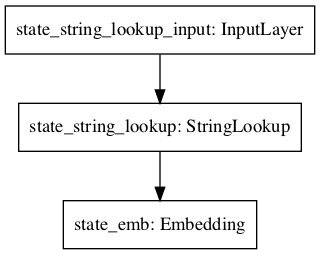

In [18]:
tf.keras.utils.plot_model(retrieval_model.user_model, to_file="project_4_3_user.png")

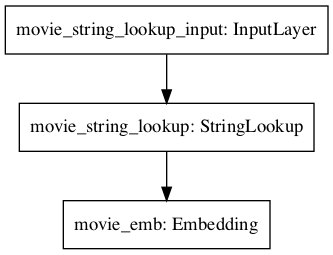

In [19]:
tf.keras.utils.plot_model(retrieval_model.movie_model, to_file="project_4_3_movie.png")

In [20]:
retrieval_model.user_model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
state_string_lookup (StringL (None,)                   0         
_________________________________________________________________
state_emb (Embedding)        (None, 10)                220       
Total params: 220
Trainable params: 220
Non-trainable params: 0
_________________________________________________________________


In [21]:
retrieval_model.movie_model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
movie_string_lookup (StringL (None,)                   0         
_________________________________________________________________
movie_emb (Embedding)        (None, 10)                12010     
Total params: 12,010
Trainable params: 12,010
Non-trainable params: 0
_________________________________________________________________
